⬆LONG Trade Entry: 159.92 | Timestamp: 2025-06-03 09:45:00+00:00  | Take Proft: 162.34857142857143 | Stop Loss: 157.82535714285711  |  PnL: $40.00  |  Equity: $1040.00 | Volume: 14285
🟢Trade closed: 2025-06-03 14:45:00+00:00 | Target hit: 2025-06-03 14:45:00+00:00 | Exit: 163.2 | TP: 162.34857142857143
🔻SHORT Trade Entry: 156.2 | Timestamp: 2025-06-04 07:15:00+00:00  | Take Proft: 153.84571428571425 | Stop Loss: 158.2305714285714  |  PnL: $41.60  |  Equity: $1081.60 | Volume: 8440
🟢Trade closed: 2025-06-04 22:15:00+00:00 | Target hit: 2025-06-04 22:15:00+00:00 | Exit: 153.65 | TP: 153.84571428571425
🔻SHORT Trade Entry: 153.33 | Timestamp: 2025-06-05 05:00:00+00:00  | Take Proft: 151.13000000000005 | Stop Loss: 155.2275  |  PnL: $43.26  |  Equity: $1124.86 | Volume: 43994
🟢Trade closed: 2025-06-05 13:45:00+00:00 | Target hit: 2025-06-05 13:45:00+00:00 | Exit: 150.37 | TP: 151.13000000000005
🔻SHORT Trade Entry: 150.37 | Timestamp: 2025-06-05 13:45:00+00:00  | Take Proft: 146.798571428571

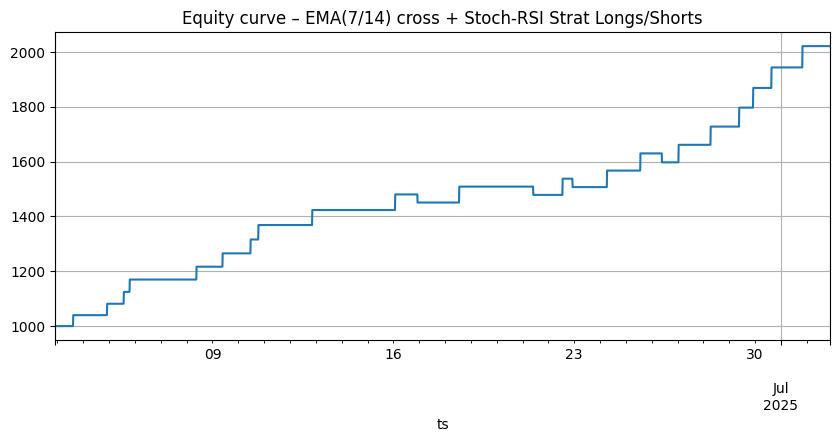

In [1]:
# pip install ccxt pandas numpy matplotlib
import ta, ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────── CONFIG ───────────────────────────────────────────
PAIR, TF, LOOKBACK_D = "SOL/USDT", "15m", 30

RISK_PCT     = 0.02      # 2 % equity risk
ATR_MULT_SL  = 2.0       # stop  = 2×ATR14
ATR_MULT_TP  = 4.0       # target= 4×ATR14  (RR = 2:1)
ADX_FLOOR  = 20
VOL_MULT = 1.6      # volume multiplier for trend filter
# ── PARAMETERS ─────────────────────────────
WICK_BUFFER  = 0.25     # ATR fraction


# ── NEW STATE FLAGS ────────────────────────
reentry_allowed = False
last_signal_dir = None
stopped_ts      = None



# ───────────────── DOWNLOAD DATA ────────────────────────────────────
ex, rows = ccxt.bybit(), []
since = ex.milliseconds() - LOOKBACK_D * 86_400_000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    rows.extend(chunk); since = chunk[-1][0] + 1

df = (pd.DataFrame(rows, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ───────────────── INDICATORS ───────────────────────────────────────
# EMAs
df["ema7"]  = df.c.ewm(span=7).mean()
df["ema14"] = df.c.ewm(span=14).mean()
df["ema28"] = df.c.ewm(span=28).mean()

# ATR14
tr  = np.maximum.reduce([df.h - df.l,
                         (df.h - df.c.shift()).abs(),
                         (df.l - df.c.shift()).abs()])
df["atr"] = pd.Series(tr, index=df.index).rolling(14).mean()

# RSI(14)
delta = df.c.diff()
gain  = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
loss  = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
rs    = gain / loss
df["rsi"] = 100 - 100/(1+rs)

# Stoch-RSI 14,3,3
rsi_min = df.rsi.rolling(14).min()
rsi_max = df.rsi.rolling(14).max()
stoch_rsi = (df.rsi - rsi_min) / (rsi_max - rsi_min)
k_fast = stoch_rsi.rolling(3).mean() * 100           # %K
d_slow = k_fast.rolling(3).mean()                    # %D (not used here)
df["k_fast"] = k_fast

# Volume MA
df["vol20"] = df.v.rolling(20).mean()

# ADX
plus_dm  = np.where(df.h.diff()>df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff()>df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr,index=df.index).rolling(14).sum()
plus_di  = 100*pd.Series(plus_dm,index=df.index).rolling(14).sum()/tr_n
minus_di = 100*pd.Series(minus_dm,index=df.index).rolling(14).sum()/tr_n
dx       = 100*(plus_di-minus_di).abs()/(plus_di+minus_di)
df["adx"] = dx.rolling(14).mean()

# ───────────────── 1-H FRAME (trend filter) ──────────────────────
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"]  = h1.close.ewm(span=50).mean()
h1["slope"]  = h1.ema50.diff(3)  # 3-bar slope

def h1_row(ts): return h1.loc[ts.floor("1H")]

# ───────────────── 4-H FRAME (bias filter) ──────────────────────
h4 = df.c.resample("4H").last().to_frame("close").ffill()
h4["ema50"] = h4.close.ewm(span=50).mean()


def h4_bias(ts):
    r = h4.loc[ts.floor("4H")]
    return r.close > r.ema50


# === signal helpers =================================================
def long_ok(bar, prev, h1row):
    cross_up = (bar.ema7 > bar.ema14) and (prev.ema7 <= prev.ema14)
    return (cross_up
            and bar.k_fast > 45
            and bar.rsi     > 45
            and bar.adx     >= ADX_FLOOR
            and h1row.close >  h1row.ema50
            and h1row.slope >  0)

def short_ok(bar, prev, h1row):
    cross_dn = (bar.ema7 < bar.ema14) and (prev.ema7 >= prev.ema14)
    return (cross_dn
            and bar.k_fast > 30        # keep your numbers
            and bar.rsi     > 30
            and bar.adx     >= ADX_FLOOR
            and h1row.close <  h1row.ema50
            and h1row.slope <  0)

# ───────────────── SIMPLE BACK-TEST ────────────────────────────────
# === back-test loop =================================================
equity = 1_000.0
pos    = None      # None or dict{dir,entry,sl,tp,risk,half}
trades = []
curve  = []

for i, (idx, bar) in enumerate(df.iterrows()):

    bar, prev = df.iloc[i], df.iloc[i-1] if i > 0 else df.iloc[i]
    h1r       = h1_row(bar.name)

    # ── manage open position ───────────────────────────────────────
    if pos:
        if (pos['dir'] ==  1 and bar.l <= pos['sl']) or \
           (pos['dir'] == -1 and bar.h >= pos['sl']):
            pnl = -pos['risk']
            equity += pnl            
            pos['time_close'] = idx
            # stop-loss
            trades.append({'exit': bar.name, 'pnl': -pos['risk']})
            direction = "⬆LONG" if pos['dir'] == 1 else "🔻SHORT"
            print (f"{direction} Trade Entry: {pos['entry']} | Timestamp: {pos['time_entry']}  | Take Proft: {pos['tp']} | Stop Loss: {pos['sl']}  |  PnL: ${pnl:.2f}  |  Equity: ${equity:.2f} | Volume: {bar.v:.0f}")
            print(f"🔴Trade closed: {idx} | Stop Loss hit: {pos['time_close']} | Exit: {bar.c} | SL: {pos['sl']}")
            pos = None

        elif (pos['dir'] ==  1 and bar.h >= pos['tp']) or \
             (pos['dir'] == -1 and bar.l <= pos['tp']):
            pnl = pos['risk'] * ATR_MULT_TP/ATR_MULT_SL
            equity += pnl
            pos['time_close'] = idx
            trades.append({'exit': bar.name,
                           'pnl' :  pos['risk']*ATR_MULT_TP/ATR_MULT_SL})
            direction = "⬆LONG" if pos['dir'] == 1 else "🔻SHORT"
            print (f"{direction} Trade Entry: {pos['entry']} | Timestamp: {pos['time_entry']}  | Take Proft: {pos['tp']} | Stop Loss: {pos['sl']}  |  PnL: ${pnl:.2f}  |  Equity: ${equity:.2f} | Volume: {bar.v:.0f}")
            print(f"🟢Trade closed: {idx} | Target hit: {pos['time_close']} | Exit: {bar.c} | TP: {pos['tp']}")
            pos = None

    # ── look for new entry ────────────
    if pos is None:
        if long_ok(bar, prev, h1r):
            stop = ATR_MULT_SL*bar.atr *1.6
            pos  = dict(dir=1, entry=bar.c,
                        sl=bar.c-stop - WICK_BUFFER * bar.atr, tp=bar.c+ATR_MULT_TP*bar.atr,
                        risk=equity*RISK_PCT, half=False, time_entry=idx, time_close=None)

        elif short_ok(bar, prev, h1r):
            stop = ATR_MULT_SL*bar.atr *1.6
            pos  = dict(dir=-1, entry=bar.c,
                        sl=bar.c+stop + WICK_BUFFER * bar.atr, tp=bar.c-ATR_MULT_TP*bar.atr,
                        risk=equity*RISK_PCT, half=False,time_entry=idx, time_close=None)

    curve.append(equity)

# ───────────────── RESULTS ─────────────────────────────────────────
eq_series = pd.Series(curve, index=df.index[-len(curve):])
wins = sum(1 for t in trades if t["pnl"] > 0)
print(f"Trades: {len(trades)}  |  Wins: {wins}  |  Win-rate: {wins/len(trades):.1%}")
print(f"Final balance: ${equity:,.0f}  |  Max DD: {100*(min(eq_series)-1_000)/1_000:.1f}%")

eq_series.plot(title="Equity curve – EMA(7/14) cross + Stoch-RSI Strat Longs/Shorts", figsize=(10,4), grid=True)
plt.show()
